In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from os import listdir
from os.path import isfile, join
import random
import numpy as np

from utils import get_iou
%matplotlib inline

In [2]:
dataset_name = "ic15"
model_name = "textfusenet"
weights = "tt"

imgs_dir = r"../../icdar2015/ch4_test_images"
labels_dir = r"../../icdar2015/Challenge4_Test_Task4_GT"

In [3]:
predictions_dir = f'../../results/{model_name}_{dataset_name}_results/{model_name}_{weights}'

In [4]:
labels_files = [f for f in listdir(labels_dir) if isfile(join(labels_dir, f))]
labels_files.sort()
print(f"labels files count: {len(labels_files)}")

labels files count: 500


In [5]:
images_files= [f for f in listdir(imgs_dir) if isfile(join(imgs_dir, f))]
images_files.sort()
print(f"images files count: {len(images_files)}")
print(f"First 3 images files: {images_files[:3]}")

images files count: 500
First 3 images files: ['img_1.jpg', 'img_10.jpg', 'img_100.jpg']


In [6]:
detection_files = [f for f in listdir(predictions_dir) if isfile(join(predictions_dir, f)) and 
                  f.startswith("detection") and f.endswith("txt")]
detection_files.sort()
print(f"detection files count: {len(detection_files)}")

detection files count: 500


In [7]:
recognition_files = [f for f in listdir(predictions_dir) if isfile(join(predictions_dir, f)) and 
                  f.startswith("recognition") and f.endswith("txt")]
recognition_files.sort()
print(f"recognitions files count: {len(detection_files)}")

recognitions files count: 500


In [8]:
results_dict = {}
for labels, detections, recognitions, img_name in zip(labels_files, detection_files, recognition_files, images_files):
    img_number = int(labels.split(".")[0].split("_")[-1])
    results_dict[img_number] = {}
    results_dict[img_number]['labels_file_name'] = labels
    results_dict[img_number]['detections_file_name'] = detections
    results_dict[img_number]['recognition_file_name'] = recognitions
    results_dict[img_number]['image_name'] = img_name
    
    #img shape
    img = cv2.imread(os.path.join(imgs_dir, img_name))
    results_dict[img_number]['image_width'] = img.shape[1]
    results_dict[img_number]['image_height'] = img.shape[0]
    
    with open(os.path.join(labels_dir, labels), encoding='utf-8-sig') as f:
        annotations = f.read().splitlines()
        
        results_dict[img_number]['labels'] = []
        for i, annot in enumerate(annotations):
            bbox = {}
            annot = annot.split(',')
            bbox['text'] = annot[-1]
            bbox['text_len'] = len(annot[-1]) if annot[-1] != '###' else -1
            
            bbox['x'] = np.array([int(annot[pos]) for pos in range(0, 7, 2)])
            bbox['y'] = np.array([int(annot[pos + 1]) for pos in range(0, 7, 2)])
            
            bbox['x1'] = min(bbox['x'])
            bbox['x2'] = max(bbox['x'])
            bbox['y1'] = min(bbox['y'])
            bbox['y2'] = max(bbox['y'])
            
            bbox['width'] = bbox['x2'] - bbox['x1']
            bbox['hight'] = bbox['y2'] - bbox['y1'] 
            results_dict[img_number]['labels'].append(bbox)
        
        results_dict[img_number]['predictions'] = []
        
        with open(os.path.join(predictions_dir, detections), encoding='utf-8-sig') as f1:
            detections = f1.read().splitlines()
            with open(os.path.join(predictions_dir, recognitions), encoding='utf-8-sig') as f2:
                recognitions = f2.read().splitlines()

                for detection, recognition in zip(detections, recognitions):
                    bbox = {}
                    bbox['text'] = recognition
                    bbox['text_len'] = len(recognition)
                    
                    detection =detection.split(",")

                    bbox['x'] = np.array([int(detection[pos]) for pos in range(0, 7, 2)])
                    bbox['y'] = np.array([int(detection[pos + 1]) for pos in range(0, 7, 2)])

                    bbox['x1'] = min(bbox['x'])
                    bbox['x2'] = max(bbox['x'])
                    bbox['y1'] = min(bbox['y'])
                    bbox['y2'] = max(bbox['y'])

                    bbox['width'] = bbox['x2'] - bbox['x1']
                    bbox['hight'] = bbox['y2'] - bbox['y1'] 
                    results_dict[img_number]['predictions'].append(bbox)
    
    

In [9]:
results_dict[1].keys()

dict_keys(['labels_file_name', 'detections_file_name', 'recognition_file_name', 'image_name', 'image_width', 'image_height', 'labels', 'predictions'])

## Display labels and predictions

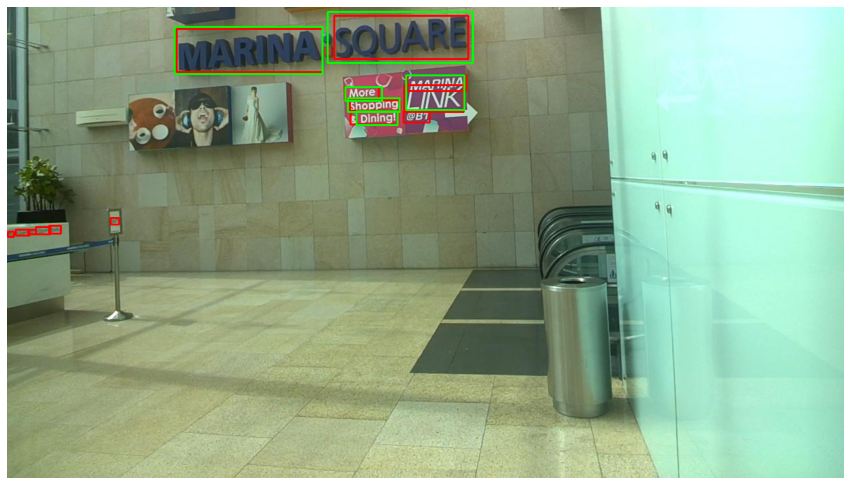

In [10]:
image_number = 107
result = results_dict[image_number]

# Transofrm bounding box annotations
fig, ax = plt.subplots( figsize=(15, 15))
img = cv2.imread(os.path.join(imgs_dir, result['image_name']))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for label in result['labels']:
    color = (255, 0, 0)
    cv2.rectangle(img, (label['x1'], label['y1']), (label['x2'], label['y2']) ,color, 2)
for prediction in result['predictions']:
    color = (0, 255, 0)
    cv2.rectangle(img, (prediction['x1'], prediction['y1']), (prediction['x2'], prediction['y2']) ,color, 2)
ax.axis('off')
ax.imshow(img);

## Match predictions with labels

In [11]:
empty_label = {key: '-' for key in results_dict[2]['labels'][0].keys()}
empty_prediction = {f"pred_{key}": '-' for key in results_dict[2]['predictions'][0].keys()}

In [12]:
pairs = []
for img_number, result in results_dict.items(): # for each image
    
    detected_labels = [] # indexes of correct detected words
    
    img_info = {key: value for key, value in result.items() if key not in ['labels', 'predictions']} # get image info
    

    for i, prediction in enumerate(result['predictions']): # for each prediction

        row = {f"pred_{key}": value for key, value in prediction.items()} # get prediction info

        iou_list = []
        for label in result['labels']: # count iou of prediction and each ground truth
            iou_list.append(get_iou(label, prediction))

        if max(iou_list) > 0.5: # if max iou biger than 0.5
            max_iou_index = iou_list.index(max(iou_list)) # get index of that label

            detected_labels.append(max_iou_index) # add index of this label do deteced labels list
            row.update(result['labels'][max_iou_index]) # add this label do detection as pair

            row['detection_status'] = "TP" # Set detection as True positive
            
            row['redable_label'] = True # set flag redable_label True by default
            if row['text'] == "###" or row['text'] == "#": # if label is ### or #
                row['recogniton_status'] = 'NA' # recognition should not be checked
                row['redable_label'] = False # set flag redable_label to False
            elif row['text'].lower() == row['pred_text'].lower(): # check if pred text aldn ground truth are the same
                row['recogniton_status'] = 'Correct'
            else:
                row['recogniton_status'] = 'Wrong'
            row['iou'] = max(iou_list)
        else: # if IoU < 0.5
            row.update(empty_label) # There is no matched label
            row['detection_status'] = "FP" # This is false positive detection
            
            row['redable_label'] = True # We want to used this predicton in metric calulus
            row['recogniton_status'] = "NA" # but recognition is not neaded
            row['iou'] = 0
        row.update(img_info)
        pairs.append(row)
        
        
    for i in range(0, len(result['labels'])): # iterate over labels
        if i in detected_labels: # If label is detected by model skip it
            continue
        row = empty_prediction.copy() # else add as False negative raw
        row.update(result['labels'][i])
        row['detection_status'] = "FN"
        row['recogniton_status'] = "NA"
        row['redable_label'] = True
        if row['text'] == "###" or row['text'] == "#": # But if it is not redable we don't want to count it
            row['redable_label'] = False
        row['iou'] = 0
        row.update(img_info)
        pairs.append(row)
    

In [13]:
df = pd.DataFrame(pairs)

In [14]:
df['dataset'] = dataset_name
df['model'] = model_name
df['weights'] = weights

df.to_csv(f"{dataset_name}_{model_name}_{weights}_results.csv", index=False)

In [17]:
df[df['redable_label'] == True]['detection_status'].value_counts()

TP    1085
FN     992
FP     113
Name: detection_status, dtype: int64

In [18]:
df.loc[100:]

,pred_text,pred_text_len,pred_x,pred_y,pred_x1,pred_x2,pred_y1,pred_y2,pred_width,pred_hight,...,iou,labels_file_name,detections_file_name,recognition_file_name,image_name,image_width,image_height,dataset,model,weights
100,marina,6,"[260, 256, 478, 482]","[102, 49, 30, 83]",256,482,30,102,226,72,...,0.904499,gt_img_107.txt,detection_res_img_107.txt,recognition_res_img_107.txt,img_107.jpg,1280,720,ic15,textfusenet,tt
101,square,6,"[495, 490, 708, 712]","[85, 23, 7, 68]",490,712,7,85,222,78,...,0.781358,gt_img_107.txt,detection_res_img_107.txt,recognition_res_img_107.txt,img_107.jpg,1280,720,ic15,textfusenet,tt
102,shopping,8,"[521, 521, 600, 600]","[160, 139, 139, 160]",521,600,139,160,79,21,...,0.770883,gt_img_107.txt,detection_res_img_107.txt,recognition_res_img_107.txt,img_107.jpg,1280,720,ic15,textfusenet,tt
103,more,4,"[517, 517, 573, 573]","[143, 122, 122, 143]",517,573,122,143,56,21,...,0.810879,gt_img_107.txt,detection_res_img_107.txt,recognition_res_img_107.txt,img_107.jpg,1280,720,ic15,textfusenet,tt
104,many,4,"[610, 610, 699, 699]","[157, 104, 104, 157]",610,699,104,157,89,53,...,0.655172,gt_img_107.txt,detection_res_img_107.txt,recognition_res_img_107.txt,img_107.jpg,1280,720,ic15,textfusenet,tt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5338,-,-,-,-,-,-,-,-,-,-,...,0.000000,gt_img_99.txt,detection_res_img_99.txt,recognition_res_img_99.txt,img_99.jpg,1280,720,ic15,textfusenet,tt
5339,-,-,-,-,-,-,-,-,-,-,...,0.000000,gt_img_99.txt,detection_res_img_99.txt,recognition_res_img_99.txt,img_99.jpg,1280,720,ic15,textfusenet,tt
5340,-,-,-,-,-,-,-,-,-,-,...,0.000000,gt_img_99.txt,detection_res_img_99.txt,recognition_res_img_99.txt,img_99.jpg,1280,720,ic15,textfusenet,tt
5341,-,-,-,-,-,-,-,-,-,-,...,0.000000,gt_img_99.txt,detection_res_img_99.txt,recognition_res_img_99.txt,img_99.jpg,1280,720,ic15,textfusenet,tt
